In [17]:
import pandas as pd
import os
import glob
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
r = requests.get('https://pypi.org/pypi/openpolicedata/json')
opd_data = r.json()
release_dates = [x[0]['upload_time'] for x in opd_data['releases'].values()]
release_dates = [pd.to_datetime(x) for x in release_dates]

In [3]:
rtd_loc = r"..\data\readthedocs"
pypi_loc = r"..\data\pypistats"
ma_win = '7D'

# Files from https://readthedocs.org/dashboard/openpolicedata/traffic-analytics/
files = glob.glob(os.path.join(rtd_loc, "readthedocs_traffic_analytics_openpolicedata_*.csv"))

csvs = []
for f in files:
    csvs.append(pd.read_csv(f).sort_values(by="Date"))


df = pd.concat(csvs, ignore_index=True)
df = df.drop_duplicates(subset=["Date","Version","Path"], keep='last').sort_values(by="Date", ignore_index=True)
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")
df = df[(df['Version']=='stable') | df['Version'].str.startswith('v')]
df.tail()

,Version,Path,Views
Date,,,
2025-03-13,stable,/examples/opd-examples/analyze_datasets.html,1
2025-03-13,stable,/getting_started/index.html,1
2025-03-14,stable,/getting_started/index.html,1
2025-03-14,stable,/datasets/source_table_dictionary.html,4
2025-03-14,stable,/index.html,14


In [4]:
df_index = df[df['Path']=='/index.html'].copy()
df_index = df_index.resample("1D").sum()
df_index['Views Filtered'] = df_index['Views'].rolling(window=ma_win, center=True).mean()
df_index.tail()

,Version,Path,Views,Views Filtered
Date,,,,
2025-03-10,stable,/index.html,4,6.714286
2025-03-11,stable,/index.html,6,8.142857
2025-03-12,stable,/index.html,10,7.666667
2025-03-13,stable,/index.html,9,8.600000
2025-03-14,stable,/index.html,14,9.750000


<Axes: xlabel='Date'>

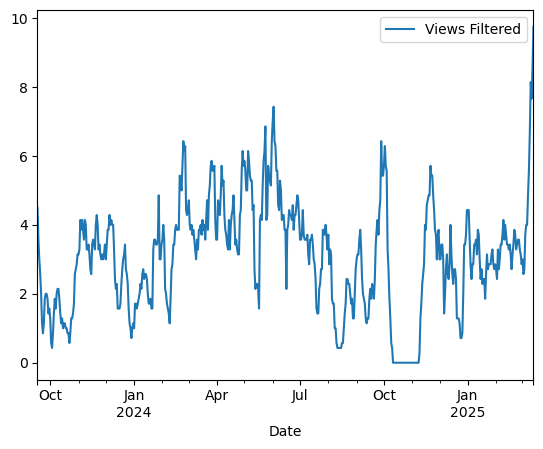

In [5]:
df_index.plot.line(y="Views Filtered")

In [6]:
# Update pypi stats
pypi = 'https://pypistats.org/api/'
r = requests.get(pypi+"packages/openpolicedata/overall", params={'mirrors':False})
r.raise_for_status()
data = r.json()

pypi_df = pd.DataFrame(data['data'])
filename = os.path.join(pypi_loc, "pypistats_"+ datetime.now().strftime("%Y%m%d")+".csv")
if not os.path.exists(filename):
    pypi_df.to_csv(filename, index=False)

pypi_df.head()

,category,date,downloads
0,with_mirrors,2024-09-15,59
1,with_mirrors,2024-09-16,67
2,with_mirrors,2024-09-17,50
3,with_mirrors,2024-09-18,10
4,with_mirrors,2024-09-19,14


In [7]:
files = glob.glob(os.path.join(pypi_loc, "pypistats_2*.csv"))

csvs = []
for f in files:
    csvs.append(pd.read_csv(f).sort_values(by="date"))

df_pypi = pd.concat(csvs, ignore_index=True)
df_pypi["date"] = pd.to_datetime(df_pypi["date"])
df_pypi = df_pypi[df_pypi['date']>df.index.min()]
df_pypi=df_pypi[df_pypi['category']=='without_mirrors']
df_pypi = df_pypi.drop_duplicates(subset=["date"], keep='last').sort_values(by="date", ignore_index=True)
df_pypi = df_pypi.set_index('date')
df_pypi = df_pypi.resample("1D").sum()
df_pypi['Downloads Filtered'] = df_pypi['downloads'].rolling(window=ma_win, center=True).mean()


df_pypi.tail(5)

,category,downloads,Downloads Filtered
date,,,
2025-03-10,without_mirrors,16,39.428571
2025-03-11,without_mirrors,69,35.714286
2025-03-12,without_mirrors,108,35.666667
2025-03-13,without_mirrors,7,41.400000
2025-03-14,without_mirrors,7,47.750000


In [8]:
# Update pypi version 3 stats
# Update pypi stats
r = requests.get(pypi+"packages/openpolicedata/python_major", params={'mirrors':False})
r.raise_for_status()
data = r.json()

pypi_ver_df = pd.DataFrame(data['data'])
filename = os.path.join(pypi_loc, "pypistats_ver3_"+ datetime.now().strftime("%Y%m%d")+".csv")
if not os.path.exists(filename):
    pypi_ver_df.to_csv(filename, index=False)

pypi_ver_df.head()

,category,date,downloads
0,3,2024-09-16,4
1,3,2024-09-17,4
2,3,2024-09-18,2
3,3,2024-09-20,2
4,3,2024-09-22,2


In [9]:
files = glob.glob(os.path.join(pypi_loc, "pypistats_ver3_*.csv"))

csvs = []
for f in files:
    csvs.append(pd.read_csv(f).sort_values(by="date"))

df_pypi_ver = pd.concat(csvs, ignore_index=True)
df_pypi_ver["date"] = pd.to_datetime(df_pypi_ver["date"])
df_pypi_ver = df_pypi_ver[df_pypi_ver['date']>df.index.min()]
df_pypi_ver=df_pypi_ver[df_pypi_ver['category']==3.0]
df_pypi_ver = df_pypi_ver.drop_duplicates(subset=["date"], keep='last').sort_values(by="date", ignore_index=True)
df_pypi_ver = df_pypi_ver.set_index('date')
df_pypi_ver = df_pypi_ver.resample("1D").sum()
df_pypi_ver['Downloads Filtered'] = df_pypi_ver['downloads'].rolling(window=ma_win, center=True).mean()


df_pypi_ver.tail(5)

,category,downloads,Downloads Filtered
date,,,
2025-03-10,3.0,8,13.714286
2025-03-11,3.0,5,11.571429
2025-03-12,3.0,30,8.500000
2025-03-13,3.0,6,10.200000
2025-03-14,3.0,2,10.750000


(19982.0, 20162.0)

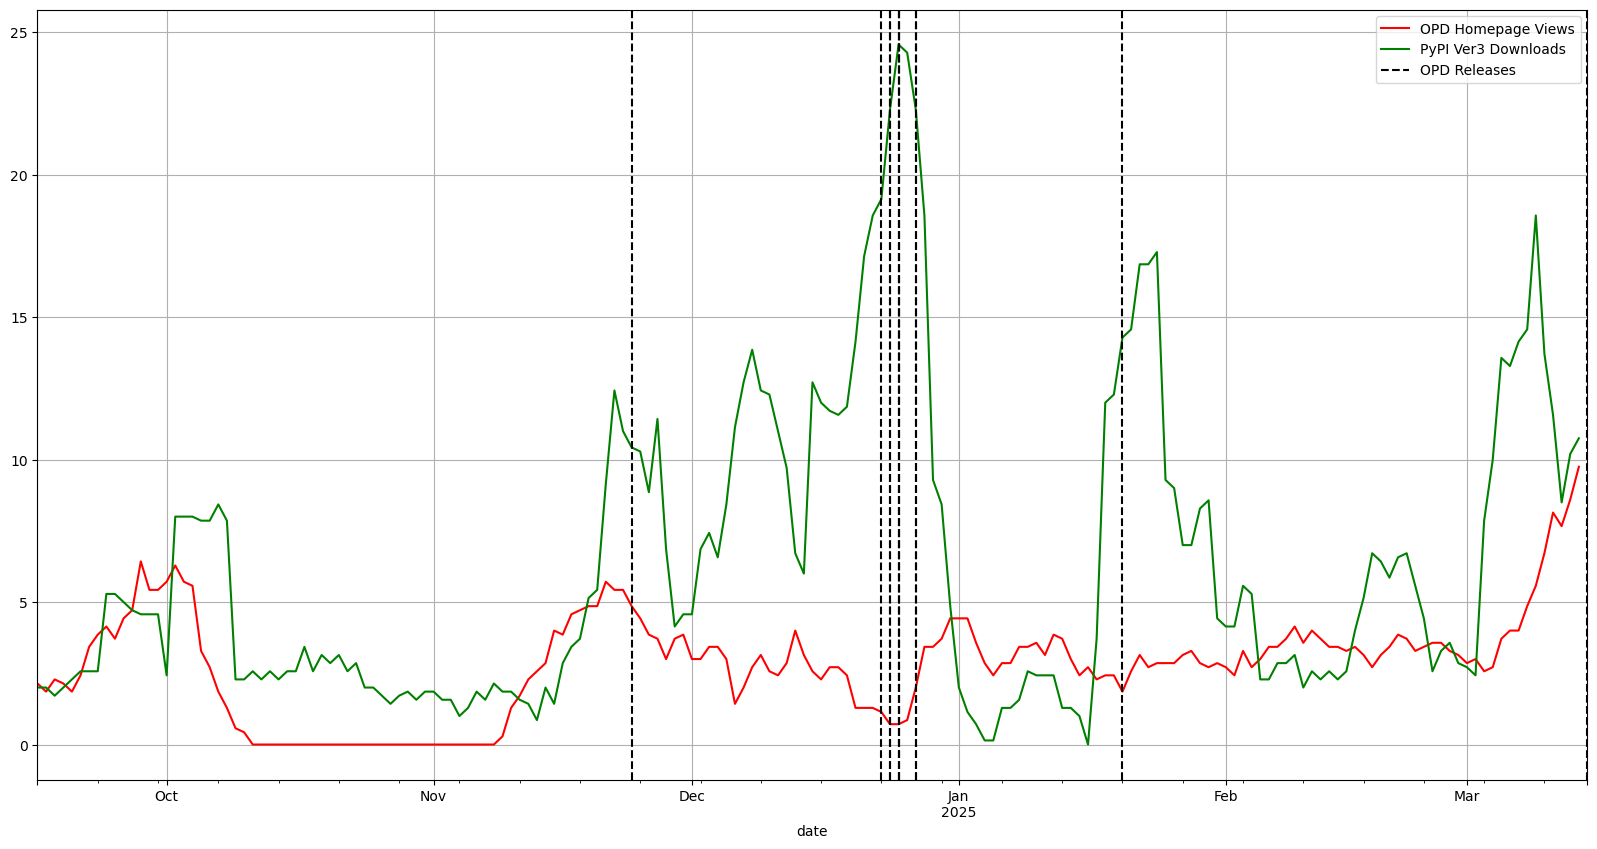

In [19]:
num_days_plot = 180

fig = plt.figure(figsize=[20,10])
ax = plt.gca()

# df_index.plot.line(y="Views Filtered", ax=axes[0], title="OPD Homepage Views", grid=True)
# df_pypi.plot.line(y="Downloads Filtered", ax=axes[1], title="PyPI Downloads", grid=True)

# df_pypi.plot.line(y="Downloads Filtered", ax=ax, label="PyPI Downloads", grid=True)

# ax2 = ax.twinx() 
df_index.plot.line(y="Views Filtered", ax=ax, label="OPD Homepage Views", grid=True, color='red')
df_pypi_ver.plot.line(y="Downloads Filtered", ax=ax, label="PyPI Ver3 Downloads", grid=True, color='green')

ax.grid(True)
ax.get_xlim()

ylim = ax.get_ylim()
vlines = ax.vlines(release_dates, ylim[0], ylim[1],'k','--')

ax.set_ylim(ylim)

leg = ax.get_legend_handles_labels()
leg[0].append(vlines)
leg[1].append('OPD Releases')
_ = plt.legend(leg[0],leg[1])

now = datetime.now()
ax.set_xlim([now-timedelta(days=num_days_plot), now])